In [2]:
import pandas as pd
import numpy as np
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 10)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


filepath = u"../data/resume_sentence_dataset_balanced2.csv"

data = pd.read_csv(filepath)
data = data.dropna()
data



,Sentence #,Word,Tag
0,0,Govardhana,Name
1,0,K,Name
2,0,Senior,Profil
3,0,Software,Profil
4,0,Engineer,Profil
...,...,...,...
720759,28831,indeed.com/r/Santosh-Ganta/4270d63f03e71ee8,Email Address
720760,28831,Kanagala/04b36892f9d2e2eb,Email Address
720761,28831,Das/152269fb5b986c26,Email Address
720762,28831,indeed.com/r/Shreyanshu-,Email Address


In [ ]:
#change date tag to Date instead of 0
#data.loc[data.index[data.Word.str.contains("[0-9]{4}$")],'Tag'] = "Date"

In [2]:
data["Tag"].value_counts()

Skills                 70668
Location               65524
Degree                 65524
Date                   65524
Profil                 65524
Email Address          65524
Name                   65524
College Name           65524
Duration               65524
O                      65416
Companies worked at    60488
Name: Tag, dtype: int64

In [3]:
## remove random O-Tag
#import random
import math

index = data.index[data['Tag'] == "O"]
O_tagSize = math.ceil((len(index)*0.9))

drop_indices = np.random.choice(index, O_tagSize, replace=False)
#data = data.drop(drop_indices)

data["Tag"].value_counts()

Skills                 70668
Location               65524
Degree                 65524
Date                   65524
Profil                 65524
Email Address          65524
Name                   65524
College Name           65524
Duration               65524
O                      65416
Companies worked at    60488
Name: Tag, dtype: int64

In [3]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

14728

In [4]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags
print(tags)

['Date', 'Email Address', 'Location', 'College Name', 'Degree', 'O', 'Companies worked at', 'Name', 'Profil', 'Duration', 'Skills']


In [5]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            print(s)
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)

In [6]:
sentences = getter.sentences

In [7]:

#pad word to a length of 50 (why ? Keras need to have same length for each input in the neural net)
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sentences]
y = [[tag2idx[w[1]] for w in s] for s in sentences]


X = pad_sequences(maxlen=max_len, sequences=X, padding="post",value=n_words - 1)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post",value=tag2idx["O"])

In [38]:
# change label to categorical
from tensorflow.keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

#X = X.reshape(X.shape[0],X.shape[1],1)
#y = y.reshape(y.shape[0],y.shape[1],1)
#X.shape,y.shape

In [39]:
# split dataset into train (input & label) test (input & label)
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)


In [21]:
import gensim
word_vectors  = gensim.models.Word2Vec.load("saved_model/word2vecEmbedding").wv

MAX_NB_WORDS = len(word_vectors.vocab)
WV_DIM = 50

nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))

# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(n_words, WV_DIM) - 0.5) / 5.0
for word, i in word2idx.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass
print(MAX_NB_WORDS)

2279


In [22]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

test_sentence = ["html"]
#model =  tf.keras.models.load_model("./saved_model/lstm_ner_model_F1_37_3.h5")
embedding_layer = Embedding(n_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=50,
                     trainable=False)

In [37]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,SpatialDropout1D
from keras.layers.normalization import BatchNormalization

input = Input(shape=(max_len,))
#model = Embedding(input_dim=n_words + 1, output_dim=50,input_length=max_len, mask_zero=True)(input)
model = embedding_layer(input)
model = SpatialDropout1D(0.2)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True,recurrent_dropout=0.1))(model)  # variational biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

model = Model(input, out)
model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            736400    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 11)            2211      
Total params: 859,411
Trainable params: 123,011
Non-trainable params: 736,400
_________________________________________________________________


In [24]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [25]:
history = model.fit(X_tr, np.array(y_tr), batch_size=256, epochs=5, validation_split=0.4, verbose=1,shuffle=True)


Train on 15568 samples, validate on 10379 samples
Epoch 1/5
15568/15568 [==============================] - 25s 2ms/step - loss: 1.3113 - accuracy: 0.5762 - val_loss: 1.1694 - val_accuracy: 0.6543
Epoch 2/5
15568/15568 [==============================] - 25s 2ms/step - loss: 1.0428 - accuracy: 0.6929 - val_loss: 0.8396 - val_accuracy: 0.7393
Epoch 3/5
15568/15568 [==============================] - 25s 2ms/step - loss: 0.7615 - accuracy: 0.7620 - val_loss: 0.6168 - val_accuracy: 0.7936
Epoch 4/5
15568/15568 [==============================] - 26s 2ms/step - loss: 0.5867 - accuracy: 0.8114 - val_loss: 0.4820 - val_accuracy: 0.8615
Epoch 5/5
15568/15568 [==============================] - 26s 2ms/step - loss: 0.4758 - accuracy: 0.8483 - val_loss: 0.3826 - val_accuracy: 0.8879


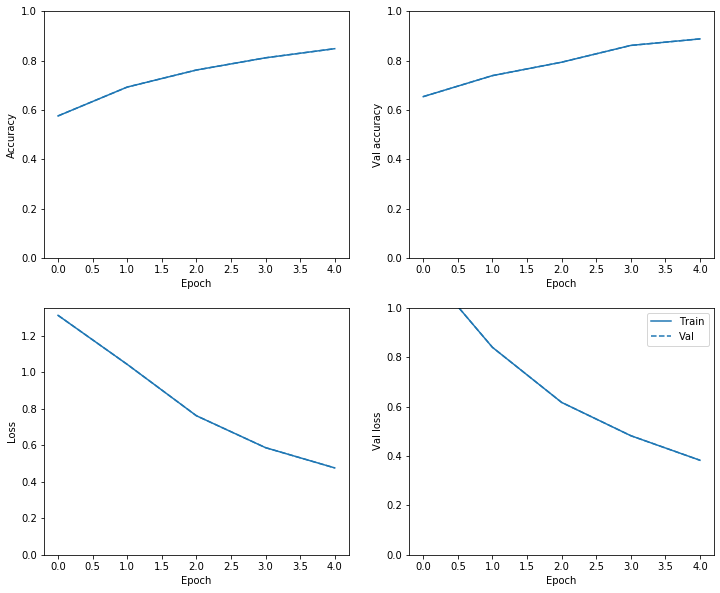

In [26]:
def plot_metrics(history):
    metrics =  ['accuracy', 'val_accuracy', 'loss', 'val_loss']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history[metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
              plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
              plt.ylim([0.8,1])
        else:
              plt.ylim([0,1])

    plt.legend()
plot_metrics(history)

In [27]:
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out


y_pred = model.predict(X_te,verbose=1)

pred_labels = pred2label(y_pred)
test_labels = pred2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
 
print(classification_report(test_labels, pred_labels))

2884/2884 [==============================] - 4s 1ms/step
F1-score: 78.3%
                     precision    recall  f1-score   support

               Name       0.59      0.62      0.61      3057
             Skills       0.90      0.90      0.90      7015
               Date       0.67      0.63      0.65       284
      Email Address       0.91      0.97      0.94      5641
Companies worked at       0.14      0.53      0.22       275
           Location       0.50      0.54      0.52       280
           Duration       0.25      0.36      0.29       274
             Profil       0.14      0.45      0.22       244
       College Name       0.88      0.81      0.84       303
             Degree       0.11      0.19      0.14       294

          micro avg       0.74      0.83      0.78     17667
          macro avg       0.79      0.83      0.81     17667



In [42]:
X_te[0]

array([ 7113,  6009,  2107,  6103,  5531,  2122,  4311,  8017,  8101,
        5497,  6151,   433,  5004,  2107, 11306,  7200,  3089,  7614,
        2107, 12828,  2531, 10899,  4218,   864,  9012, 14727, 14727,
       14727, 14727, 14727, 14727, 14727, 14727, 14727, 14727, 14727,
       14727, 14727, 14727, 14727, 14727, 14727, 14727, 14727, 14727,
       14727, 14727, 14727, 14727, 14727])

In [32]:
i = 345
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

Word            (True ): Pred
software       : Skills
Test           : Skills
Suite          : Skills
Administrator  : Skills
Team           : Skills
Operations     : Skills
Senior         : Skills
Intern         : Skills
Associate      : Skills
Admin          : Skills
Senior         : Skills
SDET           : Skills
Incident       : Skills
Escalation     : Skills
Software       : Skills
Executive      : Skills
Engineer       : Skills
SD             : Skills
Executive      : Skills
Operations     : Skills
Engineer       : Skills
Oceanic        : Skills
Engineer       : Skills
Infosys        : Skills
Executive      : Skills
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : Name
ENDPAD         : N

In [38]:
from sklearn.utils import class_weight
y_ints = [y.argmax() for y in y_tr]
value = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)
print(value)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

[1.00847293 1.07659433 1.00375242 1.00718112 1.00119617 0.99444274
 0.92321651 0.984071   1.00503544 1.00632175 1.00204681]


In [39]:
history = model.fit(X_tr, np.array(y_tr), batch_size=256,epochs=5, shuffle=True,validation_split=0.3, verbose=1,class_weight=value)

Train on 18162 samples, validate on 7785 samples
Epoch 1/5
18162/18162 [==============================] - 47s 3ms/step - loss: 1.2958 - accuracy: 0.5952 - val_loss: 1.1310 - val_accuracy: 0.6355
Epoch 2/5
18162/18162 [==============================] - 51s 3ms/step - loss: 0.9667 - accuracy: 0.7119 - val_loss: 0.7007 - val_accuracy: 0.7777
Epoch 3/5
18162/18162 [==============================] - 64s 3ms/step - loss: 0.6631 - accuracy: 0.7882 - val_loss: 0.5342 - val_accuracy: 0.8262
Epoch 4/5
18162/18162 [==============================] - 66s 4ms/step - loss: 0.5124 - accuracy: 0.8360 - val_loss: 0.3907 - val_accuracy: 0.8825
Epoch 5/5
18162/18162 [==============================] - 52s 3ms/step - loss: 0.4124 - accuracy: 0.8701 - val_loss: 0.3127 - val_accuracy: 0.9125


In [40]:
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out


y_pred = model.predict(X_te,verbose=1)

pred_labels = pred2label(y_pred)
test_labels = pred2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
 
print(classification_report(test_labels, pred_labels))

2884/2884 [==============================] - 4s 1ms/step
F1-score: 79.6%
                     precision    recall  f1-score   support

               Name       0.57      0.64      0.61      3057
             Skills       0.88      0.94      0.91      7015
               Date       0.78      0.74      0.76       284
      Email Address       0.91      0.97      0.94      5641
Companies worked at       0.18      0.45      0.26       275
           Location       0.29      0.32      0.30       280
           Duration       0.22      0.48      0.30       274
             Profil       0.17      0.41      0.24       244
       College Name       0.80      0.72      0.76       303
             Degree       0.37      0.45      0.41       294

          micro avg       0.75      0.85      0.80     17667
          macro avg       0.78      0.85      0.81     17667



In [11]:
t1 =["Amadou","NDIAYE","23","years","old","Research","and","Development","Engineer","Training","2016","2019","Diploma","of","Design","Engineer","in","Telecommunications","and","Networks","DIC","Ecole","Supérieure","Polytechnique","de","Dakar","ESP","2014","2016"]
t2 = ["University",
"Diploma",
"of",
"Technology",
"in",
"Telecommunications",
"and",
"Networks",
"DUT",
"Ecole",
"Supérieure",
"Polytechnique",
"de",
"Dakar",
"ESP",
"2013",
"2014",
"Baccalaureate",
"Series",
"S1",
"Sangalcam",
"High",
"School"]
t3 =[
"Languages",
"English",
"Professional",
"French",
"Fluent",
"Wolof",
"Fluent",
"Pular",
"native",
"Technical",
"skills",
"BIG",
"DATA",
"Hadoop",
"2",
"Sqoop",
"2",
"Storm",
"2",
"Avro",
"1",
"5",
"Nifi",
"1",
"5",
"Ambari",
"1",
"5",
"AWS"]
t4 = [
"BIG",     
"DATA",    
"platform",
"for",     
"Atos",    
"Senegal", 
"Mission", 
"s",
"and",     
"Implementation", 
"of",      
"Ambari",  
"in",      
"a",
"6",
"node",    
"cluster", 
"achievements",   
"Installation",   
"of",      
"Hortonworks",    
"Data",    
"Platform",
"and",     
"various", 
"services",
"HDFS",    
"YARN",    
"HIVE",    
"SPARK",   
"SQOOP",   
"on",      
"the",     
"cluster", 
"Cluster", 
"administration", 
"user",    
"management"     
"file",    
"and",     
"service", 
"access",  
"management",     
"Environment",    
"Centos",  
"7",
"Hortonworks"    
    
]
import json
from tensorflow.keras.preprocessing.sequence import pad_sequences
word2idx = {}
max_len = 50


with open("../app/word2idx.json", "r", encoding="utf-8") as f:
    word2idx = json.load(f)

with open("../app/tag2idx.json", "r", encoding="utf-8") as f:
    tag2idx = json.load(f)
tags = tag2idx.keys()

tags = list(tag2idx.keys())
tags

['Skills',
 'Email Address',
 'Name',
 'Degree',
 'Companies worked at',
 'Duration',
 'O',
 'Profil',
 'College Name',
 'Location',
 'Date']

In [16]:
import keras
import tensorflow as tf
import numpy as np
model2 =  tf.keras.models.load_model("../models/saved_model/lstm_ner_model_F1_37_3.h5")

In [18]:

test_sentence = t3
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)

p = model2.predict(np.array([x_test_sent[0]]))

p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))
sequences=[[word2idx.get(w, 0) for w in test_sentence]]

Word           ||Prediction
Languages      : O    
English        : Skills
Professional   : O    
French         : O    
Fluent         : O    
Wolof          : O    
Fluent         : O    
Pular          : O    
native         : O    
Technical      : Skills
skills         : O    
BIG            : O    
DATA           : Skills
Hadoop         : Skills
2              : Skills
Sqoop          : O    
2              : Skills
Storm          : O    
2              : Skills
Avro           : O    
1              : Duration
5              : Duration
Nifi           : O    
1              : Duration
5              : Duration
Ambari         : O    
1              : Duration
5              : Duration
AWS            : Skills


In [21]:

sequences = [t1,t2,t3]
pred_dict = {}
for seq in sequences:
        pred_sentence = pad_sequences(sequences=[[word2idx.get(w, 0) for w in seq]],
                                      padding="post", value=0, maxlen=max_len)
        p = model2.predict(np.array([pred_sentence[0]]))
        p = np.argmax(p, axis=-1)
        for w, pred in zip(seq, p[0]):
            pred_dict[w] = tags[pred]
            print("{:15}: {:5}".format(w, tags[pred]))

Amadou         : O    
NDIAYE         : O    
23             : O    
years          : O    
old            : O    
Research       : O    
and            : O    
Development    : O    
Engineer       : O    
Training       : O    
2016           : O    
2019           : O    
Diploma        : Degree
of             : O    
Design         : O    
Engineer       : Profil
in             : O    
Telecommunications: O    
and            : O    
Networks       : O    
DIC            : O    
Ecole          : O    
Supérieure     : O    
Polytechnique  : O    
de             : O    
Dakar          : O    
ESP            : O    
2014           : Date 
2016           : Date 
University     : College Name
Diploma        : Degree
of             : Degree
Technology     : Degree
in             : Degree
Telecommunications: O    
and            : O    
Networks       : O    
DUT            : O    
Ecole          : O    
Supérieure     : O    
Polytechnique  : O    
de             : O    
Dakar          